#### **<center> Unsupervised Topic Modeling with Semantic Similarity for NSF Research Awards Abstracts</center>**
**<center> Natalia Cadavid Aguilar</center>**

#### **NSF Research Awards Abstracts**

- **Introduction**

This dataset contains abstracts from NSF (National Science Foundation) research awards. Each abstract is stored in a separate file, and the objective is to develop an unsupervised model that classifies abstracts into topics based on semantic similarity.

- **Dataset Overview**

The dataset consists of several paper abstracts, with one abstract per file.

- **Task**

Develop an unsupervised model to group abstracts into topics and showcase a clear pipeline of your work. While accurate results are not expected, emphasize a well-defined approach. Consider creating a Jupyter notebook (for Python users) or an Rmarkdown report (for R users) and share it on GitHub.


#### **Approach Summary**
- **Data Extraction, Exploration, and Preprocessing:**
    - Explore the dataset to understand its structure and contents.
    - Remove irrelevant fields.
    - Handle missing values.

- **Feature Extraction:**
  - Utilize BERT embeddings to represent abstracts as numerical features.
  
- **Unsupervised Model:**
  - Apply the unsupervised learning technique K-Means clustering to group abstracts based on semantic similarity.
  
- **Cluster Qualitative Analysis :**
- Print abstracts for specific clusters, enabling further investigation and interpretation of the clustering results.

The diagram below offers a step-by-step visual guide to the text clustering process, starting from parsing XML files to identifying thematic groups within the extracted abstracts:

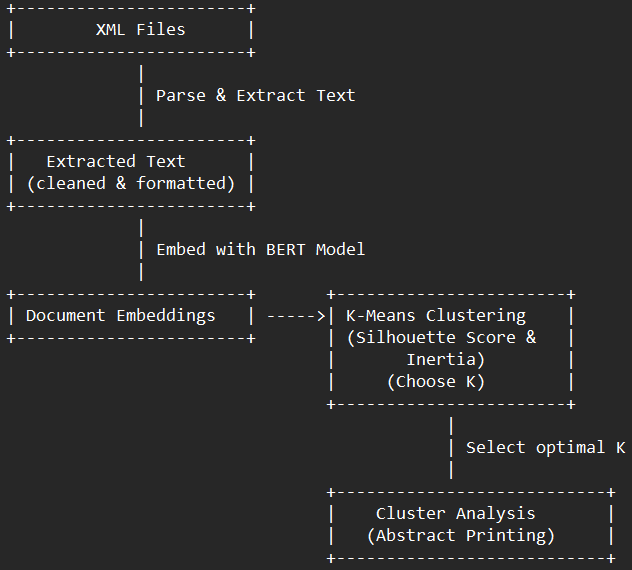!

In [2]:
# Import necessary libraries and modules
import os
import re
import textwrap
import xml.etree.ElementTree as ET

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tqdm import tqdm
import torch
from transformers import AutoModel, AutoTokenizer

**<center> Data Extraction, Exploration, and Preprocessing </center>**

**XML Files:** The process starts with XML files containing the abstracts.

**Parse & Extract Text:** These files are parsed to extract the relevant text from the "AbstractNarration" element.

**Extracted Text:** The extracted text is then cleaned and formatted for further processing.

In [3]:
# Specify the directory path containing XML files
xml_files_directory = r'C:\Users\ncada\Downloads\2020'

# List all files in the specified directory
xml_files_list = os.listdir(xml_files_directory)

In [4]:
# List to store extracted data from XML files
xml_data_list = []

# Iterate through each XML file in the provided list
for xml_filename in xml_files_list:
    # Build the full path to the XML file
    xml_file_path = os.path.join(xml_files_directory, xml_filename)

    # Parse the XML file and get the root element
    xml_tree = ET.parse(xml_file_path)
    xml_root = xml_tree.getroot()

    # Find the AbstractNarration element in the XML tree
    abstract_narration_element = xml_root.find(".//AbstractNarration")

    # Check if AbstractNarration element exists and has non-empty text
    if abstract_narration_element is not None and abstract_narration_element.text is not None:
        # Access the content of the AbstractNarration element and convert to lowercase
        abstract_narration_content = abstract_narration_element.text.lower()

        # Create a dictionary with filename and abstract narration content
        xml_filename_without_extension, _ = os.path.splitext(xml_filename)
        xml_data = {"filename": xml_filename_without_extension, "abstract": abstract_narration_content}
        
        # Append the dictionary to the list
        xml_data_list.append(xml_data)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(xml_data_list)
print(len(df))

# Drop duplicate rows based on the 'abstract' column and reset the index
df = df.drop_duplicates(subset='abstract')
df = df.reset_index(drop=True)

print(len(df))

13159
11141


In [6]:
# Display a random sample of 15 abstracts from the 'abstract' column in the DataFrame
print(df['abstract'].sample(15))

403      this award supports participation by graduate ...
3599     variability in the transport of heat, freshwat...
5005     engineers need to be able to use powerful comp...
10827    the study of families of orthogonal polynomial...
3298     coordinated online harassment by collections o...
3670     this award will provide support for the annual...
5390     research and education in volcanology, geochem...
5891     this project examines the impact of the covid-...
5112     non-technical description:&lt;br/&gt;the soft ...
11008    the new montana engineering education research...
11035    the funds will provide travel support for up t...
1001     inflammation is a characteristic feature of ma...
3845     this major research instrumentation grant supp...
2934     the broader impact of this small business inno...
5459     nontechnical abstract:&lt;br/&gt;the electrica...
Name: abstract, dtype: object


In [7]:
def clean_text(input_text):
    """
    Clean the input text by removing specified patterns.

    Parameters:
    - input_text (str): The text to be cleaned.

    Returns:
    - str: The cleaned text.
    """
    # Define the patterns to remove
    patterns_to_remove = [
        r'nontechnical summary\s*:',  # Allow for optional spaces after "nontechnical summary" and before ":"
        r'nontechnical summary',
        r'non-technical summary',
        r'non-technical abstract',
        r'non-technical abstract\s*:',
        r'non-technical description',
        r'non-technical description\s*:', # Allow for optional spaces after "nontechnical summary" and before ":"
        r'non technical\s*:',
        r'&lt;br/&gt;',
        r'&lt;',
        r'&gt;'
    ]

    # Remove HTML tags first
    cleaned_text = re.sub(r'<[^>]*>', '', input_text)

    # Apply the additional patterns
    for pattern in patterns_to_remove:
        cleaned_text = re.sub(pattern, '', cleaned_text, flags=re.IGNORECASE)

    return cleaned_text.strip()


df['abstract'] = df['abstract'].apply(lambda x: clean_text(x))

**<center> Feature Extraction </center>**

**Embed with BERT Model:** The BERT model is used to generate numerical representations (embeddings) of the cleaned text.

**Document Embeddings:** These embeddings capture the semantic meaning of the text and are used for clustering.

In [8]:
# Load the BERT model and tokenizer
model_name = "bert-base-uncased"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
# Function to get the document representation as a tensor
def get_embedding(document):
    """
    Get the document representation as a tensor using the BERT model.

    Parameters:
    - document (str): The input document for which to compute the embedding.

    Returns:
    torch.Tensor: The document embedding as a PyTorch tensor.
    """    
    tokens = tokenizer(document, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings

In [10]:
# Create a new column in the DataFrame to store embeddings
df['abstract_embedding'] = np.nan

# List to store embeddings
embedding_list = []

# Function to compute embeddings for a specified range of indices
def compute_embeddings_for_range(df, start_index, end_index, max_seq_length=512):
    """
    Compute embeddings for a specified range of indices in the DataFrame.

    Parameters:
    - df: DataFrame containing the abstracts and other information.
    - start_index: Starting index for the range (inclusive).
    - end_index: Ending index for the range (exclusive).
    - max_seq_length: Maximum sequence length for text truncation (default is 512).

    Returns:
    None

    This function iterates over the specified index range in the DataFrame, retrieves
    the text from the 'abstract' field, truncates it if necessary, and computes the
    embedding using the get_embedding function. The resulting embeddings are then
    stored in the global embedding_list.

    Note:
    - The global variable embedding_list should be defined before calling this function.
    """    
    # Iterate over the specified index range
    for index in range(start_index, end_index):
        # Get the text from the 'abstract' field
        abstract_text = df.at[index, 'abstract']

        # Truncate the text if necessary
        truncated_text = abstract_text[:max_seq_length]

        # Get the embedding and store it in the list
        embedding = get_embedding(truncated_text).numpy()
        embedding_list.append(embedding)

In [11]:
# Use the function with a specific range
compute_embeddings_for_range(df, start_index=0, end_index=11141)

In [12]:
# Update the 'abstract_embedding' column with the computed embeddings
df['abstract_embedding'] = embedding_list

**<center> Unsupervised Model </center>**

**K-Means Clustering:** The K-Means algorithm groups the document embeddings into different clusters based on their similarity.

**Silhouette Score & Inertia:** The elbow curve method and silhouette score are used to choose the optimal number of clusters (K).

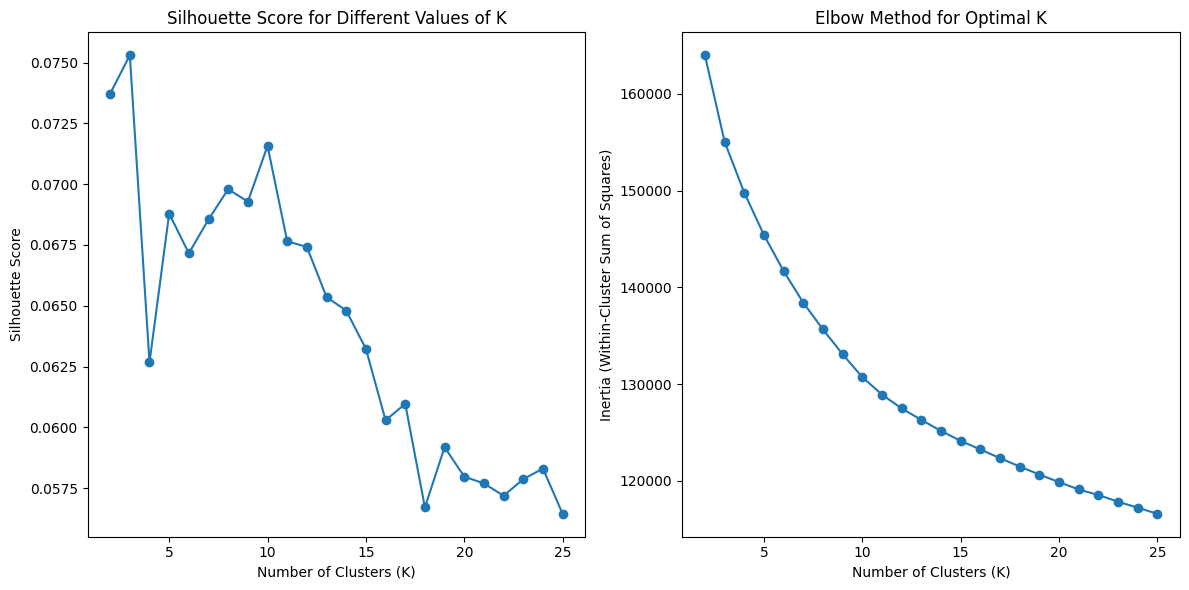

In [13]:
# Convert the 'abstract_embedding' column to a NumPy array
X = np.array(df['abstract_embedding'].tolist())

# List to store silhouette_score values
silhouette_scores = []

# List to store inertia (within-cluster sum of squares)
inertia_values = []

# Range of k values to be tested
k_values = range(2, 26)

# Iterate over each k value
for k in k_values:
    # Initialize and fit the KMeans model
    kmeans = KMeans(n_clusters=k, n_init=15, random_state=42)
    kmeans.fit(X)

    # Calculate silhouette_score and append it to the list
    silhouette = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette)

    # Append inertia (within-cluster sum of squares) to the list
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(12, 6))

# Plot Silhouette Score on the left subplot
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

# Plot Inertia on the right subplot
plt.subplot(1, 2, 2)
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

Based on the elbow curve and silhouette score analysis, we chose 10 as the optimal number of clusters for our abstracts. This number strikes a good balance between granularity and interpretability, allowing us to identify distinct but relevant groups for further analysis

In [15]:
# Set the number of clusters
n_clusters = 10

# Initialize and fit the KMeans model with the specified number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=15, random_state=42)

# Predict cluster labels and assign them to the 'cluster' column in the DataFrame
df['cluster'] = kmeans.fit_predict(X)

 **<center> Cluster Qualitative Analysis </center>**

**Abstract Printing:** A function is defined to print a specified number of abstracts from a given cluster, allowing for qualitative analysis of the clusters.


In [16]:
def print_abstracts_for_cluster(df, cluster_number, num_abstracts=3, max_chars=300):
    """
    Print a specified number of abstracts from a given cluster in the DataFrame.

    Parameters:
    - df: DataFrame containing the abstracts and cluster information.
    - cluster_number: The cluster number for which abstracts should be printed.
    - num_abstracts: Number of abstracts to print (default is 3).
    - max_chars: Maximum number of characters to print for each abstract (default is 300).

    Returns:
    None
    """
    # Check if 'cluster' column exists in the DataFrame
    if 'cluster' not in df.columns:
        print("Error: 'cluster' column not found in the DataFrame.")
        return

    # Filter the DataFrame by cluster condition
    cluster_df = df[df['cluster'] == cluster_number]

    # Counter to keep track of printed abstracts
    printed_abstracts = 0

    # Iterate over the abstracts in the filtered DataFrame
    for index, row in cluster_df.iterrows():
        # Truncate abstract text to a certain maximum number of characters
        truncated_abstract = row['abstract'][:max_chars]

        # Print each truncated abstract
        print("\n".join(textwrap.wrap(truncated_abstract, width=80)))
        print("")

        # Increment the counter
        printed_abstracts += 1

        # Break the loop after printing the specified number of abstracts
        if printed_abstracts == num_abstracts:
            break

With the cluster labels assigned by KMeans, we can now delve deeper into the abstracts within each group. This will allow us to identify shared themes, topics, and patterns, providing valuable insights into the overall content of the data.

Cluster 0 seems to align with the general topic: "Biology and Technology in Organismal Dynamics"

In [19]:
cluster_0 = print_abstracts_for_cluster(df, 0)

head and heart development are closely intertwined during embryonic development
in vertebrates. they share molecular regulatory mechanism as well as some
progenitor cell populations. both head and heart, are made from a multitude of
cells, which include mesodermal cells that form musculature and neu

this project investigates how magnetic resonance image (mri) signals change as
iron oxide nanoparticles interact with bioactive molecules. the understanding of
such signal changes provides a scientific foundation to monitor drug delivery
and release using mri, which will significantly improve the tr

the goal of this project is to investigate the relationship between metal uptake
and antibiotic resistance in plants. plants mine the soil to extract minerals
and in so doing, may take up antibiotics produced by soil microorganisms that
adversely affect normal plant function. how plants maintain ade



Cluster 1 seems to align with the general topic: "Equity and Inclusion"

In [20]:
cluster_1 = print_abstracts_for_cluster(df, 1)

this collaborative research project, involving michigan state university, the
university of north texas and the university of michigan, will examine whether
epistemic exclusion, a form a scholarly devaluation, may create a barrier to the
full inclusion and participation of women and faculty of color

the proposed project seeks to examine and understand individual differences
underlying the occurrence of false memories, which is defined as remembering an
event incorrectly or differently than how it originally occurred. the
investigation of individual differences underlying both cognitive and neur

growing evidence about the powerful effects of skillful teaching on students’
learning creates a need for professional development that impacts teachers’
actual practice. teaching practices have been shown to play a crucial role in
the reproduction or disruption of injustice. this project aims to cr



Cluster 2 seems to align with the general topic: "Digital Transformation"

In [21]:
cluster_2 = print_abstracts_for_cluster(df, 2)

more homes and industries are adopting connected technology solutions known as
the internet of things (iot).  as a result, the workforce is facing a growing
skills gap. trained technicians are needed to develop, adjust, install, and
troubleshoot iot technologies, as well as to analyze the data that

this project will develop a new standards-based and industry-validated data
analytics curriculum that integrates unmanned aerial vehicles (uavs) into an
existing geospatial technology degree program. innovations in uav technology
have increased the types and volume of data that can be collected for

this grant will develop a novel, deeply integrated physics-based data-driven
approach to assess and enhance the resilience of power transmission systems
impacted by climatic extremes. the us electricity infrastructure is increasingly
prone to climatic risks that cause wide-spread and sustained outag



Cluster 3 seems to align with the general topic: "Materials Science"

In [22]:
cluster_3 = print_abstracts_for_cluster(df, 3)

biomedical adhesive polymers are nonmetallic materials which possess the ability
to join two tissue surfaces together via bonding. targeted tissues may include
everything from hard tissues (bone, tooth, cartilage) to soft tissues (most
other organs). the most common application of biomedical adhesiv

energy storage at an affordable cost has emerged as one of the challenging
issues for the energy sector, being critical for a wide range of applications
ranging from electric vehicles to grid storage of renewable electricity. the
high cost and scarcity of lithium and transition metal (cobalt) resour

this award is funded jointly by the condensed-matter-and-materials-theory
program in the division of materials research and by the hbcu-up program in the
division of human-resource development.the research project "excellence in
research: processes and interactions in hybrid plasmonic systems" invol



Cluster 4 seems to align with the general topic: "Applied Mathematics"

In [23]:
cluster_4 = print_abstracts_for_cluster(df, 4)

this project will use tools from analysis to investigate fundamental
mathematical models for physical systems driven to equilibrium by surface
tension effects. a complete mathematical understanding of these systems is
useful in addressing biological and engineering problems of mechanical nature,
as

operator theory and matrix analysis are both fundamental areas of mathematics.
in large part, they were originally developed to provide a theoretical basis for
quantum mechanics and other physical phenomena. an increasing number of
application areas have emerged as a result of breakthroughs in opera

the principal investigator (pi) will investigate a series of problems in
mathematics with applications to diverse areas of science. a good number of the
issues the pi plans to address are a natural continuation of problems he has
explored recently that keep progressing and diffusing through a wider



Cluster 5 seems to align with the general topic: "Emerging Technologies"

In [24]:
cluster_5 = print_abstracts_for_cluster(df, 5)

this project promotes the progress of science in quantum computing algorithms
and cryptologic techniques in order to improve security of encrypted
information, which will have national security and defense applications.
currently, the commonly used encryption algorithms such as rsa are considered “u

by 2025, driverless cars will be an integral part of daily transportation.
understanding the reliability of self-driving cars is a crucial step to ensuring
that the impending ubiquity of self-driving cars causes as few fatalities as
possible. components like actuators, sensors, and computational ele

this project focuses on designing control mechanisms for a networked system with
unknown structure by making use only of non-invasive observations. by non-
invasive observations, it is meant that what is being measured is not the system
reaction to actively injected inputs, but rather the system beha



Cluster 6 seems to align with the general topic: "Fundamental Forces in Physics"

In [25]:
cluster_6 = print_abstracts_for_cluster(df, 6)

understanding the structure and properties of the atomic nucleus, which is about
100,000 times smaller than the atom it lives inside, and the fundamental forces
between the protons and neutrons that constitute the nucleus, has been made
possible by quantum theory. in quantum mechanics, this informat

the coulomb electrostatic interaction is one of the fundamental forces in
nature, governing how elementary charged particles interact. for example, stars
are essentially plasmas - that is gases of positively charged ions and
negatively charged electrons attracting and repelling one another according

understanding the close interconnection between turbulence and magnetic
reconnection has been of increasing importance to the broader solar and space
physics community.  turbulence is a fundamental physical process of transferring
energy from large-scale motions to small kinetic scales, where the tu



Cluster 7 seems to align with the general topic: "Atmosphere, Environment, and Human Activities"

In [26]:
cluster_7 = print_abstracts_for_cluster(df, 7)

greenhouse gases such as carbon dioxide (co2) and nitrous oxide (n2o) are
important heat-trapping gases in the atmosphere, contributing to changes in
global climate. nitrous oxide is present at a much lower concentration but is
about 300 times more powerful a greenhouse gas than co2. cropland soils

fire plays a key role in earth's ecosystem dynamics with profound effects on
biogeochemical processes, climate, and environmental quality beyond the
significant threat to people and infrastructures. this year has seen the most
forest fires in the amazon basin of brazil since 2010, providing a compel

this award supports building a regional center for atmospheric studies at the
historical howard university beltsville campus (hubc) observation site. the
project will enhance the atmosphere observational capability in the greater
washington-baltimore area with a suite of measurements such as wind sp



Cluster 8 seems to align with the general topic: "Devastating Diseases"

In [27]:
cluster_8 = print_abstracts_for_cluster(df, 8)

prevention, mitigation, and eradication of hiv has been the focus of
governments, scientists, and public health professionals for decades. recent
reports, such as the “ending the hiv epidemic: a plan for america” distributed
by the us department of health and human services, have generated a renewed

glioblastoma multiforme (gbm) is the deadliest form of brain tumor. patients
typically survive only 12-15 months after their initial diagnosis. therefore,
new treatments for gbm are urgently needed. however, finding new therapies for
gbm has been challenging, largely due to the lack of models that a

calcification of soft tissues (e.g. arteries) is a hallmark of several
cardiovascular diseases like aortic aneurysms and atherosclerosis. calcific
deposits lead to adverse consequences such as stiffening of arteries and
disruption of normal blood flow, often leading to morbidity and mortality. the g



Cluster 9 seems to align with the general topic: "Social Challenges"

In [28]:
cluster_9 = print_abstracts_for_cluster(df, 9)

the national academy of engineering identified solving “complex social issues”
as a grand challenge for the 21st century. this project aims to serve the
national interest by preparing engineers to work in interdisciplinary teams that
can address such complex challenges.   the university of notre dam

this award provides three years of funding to help defray the expenses of
participants in the semi-annual conference series "brazos analysis seminar"
2020-2022, the first meeting of which will be held march 28-29, 2020 at texas
a&amp;m university. subsequent meetings will rotate among university of

research initiation awards provide support for junior and mid-career faculty at
historically black colleges and universities who are building new research
programs or redirecting and rebuilding existing research programs. it is
expected that the award will (1) further the faculty member's research c

